Imports

In [21]:
import json
from pycsp3 import *
import matplotlib.pyplot as plt
from matplotlib import patheffects
import math
import tkinter as tk
from tkinter import filedialog
tk.Tk().withdraw()
#tkinter is not used anymore because it often crash, I kept the import just in case the user wanna try his luck.
#or you can mannually enter the file's path and avoid problems

''

Initializing some global variables.

In [22]:
machines_array = []
tasks_array = []
ressources_users_only_tasks_array=[]
n_ressources=0
ntasks=0
nMachines=0

Function take an array of arrays. Each value within a nested array will be linked to all values in previous arrays with same index.

In [23]:
def link_values_pairwise(arrays):
    result = {}
    for j in range(1, len(arrays)):
        array2 = arrays[j]
        for k in range(len(array2)):
            val2=array2[k]
            if val2 is not None:
              if not (val2 in result) :
                result[val2] = []
              for i in range(j):
                array1 = arrays[i]
                val1=array1[k]
                if val1 is not None and val1 not in result[val2]:
                  result[val2].append(val1)
    return result

Function to draw results

In [24]:
def draw_schedule(activities, end, width=15, height=8):
    n_machines=len(activities)
    fig, ax = plt.subplots(figsize=(width, height)) 
    ax.set_xlim(0, end+1)
    ax.set_ylim(0, n_machines + 1)
    for i, activity_line in enumerate(activities, start=1):
        for activity in activity_line:
            start_time = activity['start_time']
            duration = activity['duration']
            end_time = start_time + duration
            ax.plot([start_time, end_time], [i, i], linewidth=20, solid_capstyle='butt')
            text_x = (start_time + end_time) / 2
            text_y = i
            mytxt = ax.text(text_x, text_y, activity['name'], ha='center', va='center', color='white', fontsize=12)
            mytxt.set_path_effects([patheffects.withStroke(linewidth=3, foreground='black')])

    ax.set_yticks(range(1, n_machines + 1))
    ax.set_yticklabels([f'Machine {i}' for i in range(1, n_machines+1)])
    ax.set_xlabel('Time')
    ax.set_title("Tasks execution took "+str(end)+" units of time")
    plt.grid(True)
    plt.show()

Reading Data from either a Prolog or JSON file.

In [25]:
def read_input(input_file):
    global n_ressources
    global machines_array
    global tasks_array
    machines_array = set()
    tasks_array = []

    if input_file.endswith('.pl'):
        print(f'file : {input_file}')
        with open(input_file, 'r') as file:
            for line in file:
                if line.startswith('test('):
                    big_parts = line.split('[')
                    duration = int(big_parts[0].split(',')[1].strip())
                    
                    machines = big_parts[1].replace(' ','').replace(']', '').replace("'", '').replace('m', '').split(',')
                    machines = [(int(machine)-1) for machine in machines if machine.isdigit()]
                    
                    resources = big_parts[2].split(']')[0].replace(' ','').replace('[', '').replace("'", '').replace('r', '').split(',')
                    resources = [(int(resource)-1) for resource in resources if len(resource)>0]
                    
                    if len(machines)>0:
                        tasks_array.append([duration, machines, resources])
                    else:
                        tasks_array.append([duration, machines_array, resources])

                elif line.startswith('% Number of machines'):
                    machines_array = sorted(range (int(line.split(':')[1].strip())))
                elif line.startswith('% Number of resources'):
                    n_ressources = int(line.split(':')[1].strip())

    elif input_file.endswith('.json'):
        print(f'file : {input_file}')
        file = open(input_file)
        file_data = json.load(file)
        n_ressources=file_data['nResources']
        machines_array = sorted(range (int(file_data['nMachines'])))
        for task in file_data['tests']:
            if len(task['machines'])>0:
                tasks_array.append([int(task['duration']), task['machines'], task['resources']])
            else:
                tasks_array.append([int(task['duration']), machines_array, task['resources']])
    else:
        print("error : unknown format")
        return False
    return True

Rough estimation of lower bound. Help reducing the size of the domaine of score.

In [26]:
def estimation_of_lower_bound():
    ressources_min_times=[0 for _ in range(n_ressources)]
    for task in tasks_array:
        for ressource in task[2]:
            ressources_min_times[ressource]+=task[0]
    return max(ressources_min_times)

get a list of tasks, and a new task. Check if all thoses tasks can be executed on same time on different machines. Does not check what ressources are needed.

In [27]:
def allDifferentMachines(tasks_indexs, new_task):
    tasks_indexs.add(new_task)
    if len(tasks_indexs)==1:
        return True
    
    #mymin = min(previous_min,len(tasks_array[new_task][1]))
    if len(tasks_array[new_task][1])>=len(tasks_indexs):
        return True
    clear()
    tasks_machines = []
    for index in tasks_indexs:
        tasks_machines.append(Var(dom=set(tasks_array[index][1]), id='task_machine'+str(index)))
    satisfy(
        AllDifferent(tasks_machines)#using pycsp to check if all task can be executed on different valid machines
    )
    result = solve()
    if result != SAT:
        tasks_indexs.remove(new_task)
        return False
    return True

Perhaps the most important part of the code. This function generate sets of tasks that can be executed in parallel. thoses tasks will be forced to execute on different machines. changing sorting criteria for greedy_ressources_order can heavily influence performance. take two optionnal arguments used in sorting.

In [28]:
def orderGenerator(length_divider=500, ressources_divider=2):
    greedy_order = sorted(range(ntasks), key=lambda i: (-tasks_array[i][0], -len(tasks_array[i][2]), -len(tasks_array[i][1])))
    global biggest_task_ever
    biggest_task_ever = tasks_array[greedy_order[0]][0]
    #greedy_order = sorted(range(ntasks), key=lambda i: (-tasks_array[i][0], -len(tasks_array[i][1]), len(tasks_array[i][2])))#order by higher length,
    #greedy_order = sorted(range(ntasks), key=lambda i: (-len(tasks_array[i][2]), -tasks_array[i][0], -len(tasks_array[i][1])))
                                                                #then higher number of available machines, then lower number of needed ressources
    print(greedy_order)
    greedy_ressources_order = sorted(range(ntasks), key=lambda i: (- math.ceil(len(tasks_array[i][2])/ ressources_divider)*math.ceil(tasks_array[i][0]/ length_divider), -len(tasks_array[i][1])))
    #global ressources_users_only_tasks_array
    ressources_users_only_by_length=[]
    ressources_users_only_by_ressources=[]
    for index in greedy_order:#greedy_ressources_order:
        if len(tasks_array[index][2])>0:
            ressources_users_only_by_length.append(index)
    for index in greedy_ressources_order:#greedy_ressources_order:
        if len(tasks_array[index][2])>0:
            ressources_users_only_by_ressources.append(index)
        else:
            break
    non_ressources_users_greedy=[x for x in greedy_order if x not in ressources_users_only_by_length]
    my_batches=[]
    #old_tabu_ressources = set([i for i in range(n_ressources)])
    updated_machines_number=nMachines
    ressources_free_usage=[0 for _ in range(n_ressources)]
    ressources_users=[] # [ressource number]
    non_ressources_users=[]
    while len(non_ressources_users_greedy)!=0 or len(ressources_users_only_by_length)!=0:#exit when you're done assigning tasks
        tabu_ressources = set()
        current_batch = set()
        #machines_usage=[0 for _ in range(nMachines)]
        #updated_ressources_number=len(old_tabu_ressources)
        ressources_users.append([None for _ in range(n_ressources)])
        iteration = len(ressources_users)-1

        # Priority selection of ressource users
        if len(ressources_users)>1 :
            if max(ressources_free_usage)!=min(ressources_free_usage) and len(non_ressources_users_greedy)<= nMachines-n_ressources:
                #print(ressources_free_usage)
                scores = []
                for tasks_index in ressources_users_only_by_ressources:
                    task_score = 0
                    for ressource in tasks_array[tasks_index][2]:
                        task_score=max(task_score, tasks_array[tasks_index][0]-ressources_free_usage[ressource])
                    scores.append(task_score)
                #sorted_indices = [index for index, _ in sorted(enumerate(scores), key=lambda x: (x[1], x[0]))]

                for index in range(len(ressources_users_only_by_ressources)):
                    tasks_index=ressources_users_only_by_ressources[index]
                    if len(tabu_ressources)==n_ressources:
                        break
                    #skip=False
                    if scores[index] == tasks_array[tasks_index][0]:
                            continue
                    #print(f" t{tasks_index} score = {scores[index]}")
                    if(tabu_ressources.isdisjoint(tasks_array[tasks_index][2])):
                        if allDifferentMachines(current_batch, tasks_index):
                            for ressource in tasks_array[tasks_index][2]:
                                tabu_ressources.add(ressource)
                                ressources_users[iteration][ressource]=tasks_index
                ressources_users_only_by_ressources = [x for x in ressources_users_only_by_ressources if x not in current_batch]
                if len(tabu_ressources)!=0:
                    print(f"choosen by priority : {current_batch}")
        # ------------------------------------------------------------------- Very Important decision here, priority to thoses who use a lot of ressources ? or biggests tasks ?
        for tasks_index in ressources_users_only_by_ressources:
            if len(tabu_ressources)==n_ressources:
                break
            if len(tasks_array[tasks_index][2])>0:
                if(tabu_ressources.isdisjoint(tasks_array[tasks_index][2])):
                    if allDifferentMachines(current_batch, tasks_index):
                        for ressource in tasks_array[tasks_index][2]:
                            tabu_ressources.add(ressource)
                            ressources_users[iteration][ressource]=tasks_index
        #Update the the ressource free array Here
        if len(non_ressources_users_greedy)<= nMachines-n_ressources:
            max_value = max(ressources_free_usage)
            ressources_free_usage = [max_value - x for x in ressources_free_usage]
            for task in current_batch:
                tmp_max=0
                for ressource in tasks_array[task][2]:
                    ressources_free_usage[ressource]+=tasks_array[task][0]
                    tmp_max=max(tmp_max, ressources_free_usage[ressource])
                for ressource in tasks_array[task][2]:
                    ressources_free_usage[ressource]=tmp_max
            #min_value = min(ressources_free_usage)
            #ressources_free_usage = [x - min_value for x in ressources_free_usage]
            max_value = max(ressources_free_usage)
            ressources_free_usage = [max_value - x for x in ressources_free_usage]
        
        ressources_users_only_by_length= [x for x in ressources_users_only_by_length if x not in current_batch]
        ressources_users_only_by_ressources= [x for x in ressources_users_only_by_ressources if x not in current_batch]

        #if len(tabu_ressources)==0:
        #old_tabu_ressources=tabu_ressources

        #greedy_order = [x for x in greedy_order if x not in current_batch]
        non_ressources_users.append([])

        for tasks_index in non_ressources_users_greedy:
            if len(current_batch)==updated_machines_number:# gain time, but maybe condition is kinda fucked up because of some task being denied entry to the batch due to ressources incompatibilities ?
                    break
            if allDifferentMachines(current_batch, tasks_index):
                non_ressources_users[iteration].append(tasks_index)
                
        non_ressources_users_greedy = [x for x in non_ressources_users_greedy if x not in current_batch]

        updated_machines_number=len(current_batch)
        #print(f"{current_batch}|{greedy_order}")
        my_batches.append(current_batch)
        print(ressources_users[len(ressources_users)-1])
    return my_batches, ressources_users, non_ressources_users


Open file manager to select a file. this block may takes a lot of time because it call the previous function, which can take a lot of computations.

In [29]:
#file selector disabled because it oftens crash, feel free to try it if you want
#if read_input(filedialog.askopenfilename(filetypes=[("JSON or Prolog", "*.json;*.pl")])):
if read_input(input("Enter input file's path")):
    ntasks=len(tasks_array)
    nMachines=len(machines_array)
    all_batches, ressources_users, non_ressources_users = orderGenerator()
    ressource_links_map = link_values_pairwise(ressources_users)
    print(f"all batches {len(all_batches)} {all_batches}")
    #print(f"ressources users per batch {ressources_users}")
    print(f"incompatibilities : {ressource_links_map}" )

file : ./tests_folder/t40m10r3-2.json
[37, 3, 2, 5, 33, 1, 9, 23, 19, 20, 15, 0, 22, 17, 27, 30, 4, 28, 10, 12, 21, 34, 26, 16, 39, 24, 32, 35, 29, 13, 7, 8, 11, 18, 31, 38, 36, 14, 25, 6]
[23, 20, 1]
[32, 32, 32]
[None, 28, 25]
[None, None, 29]
[None, 36, 36]
all batches 5 [{1, 2, 3, 33, 37, 5, 9, 19, 20, 23}, {32, 0, 4, 10, 12, 15, 17, 22, 27, 30}, {34, 35, 39, 13, 16, 21, 24, 25, 26, 28}, {38, 7, 8, 6, 11, 14, 18, 29, 31}, {36}]
incompatibilities : {32: [23, 20, 1], 28: [20, 32], 25: [1, 32], 29: [1, 32, 25], 36: [20, 32, 28, 1, 25, 29]}


defining the problem's variables. at the same time, I add the contraint AllDifferent that force tasks in same groupe to execute on different machines. There is no contraint making tasks execute on a correct machine because that is done at the definition of the domaine of task_machine of each task.

In [32]:
clear()
tasks_machines = [None for _ in range(ntasks)]
tasks_starts= [None for _ in range(ntasks)]
worst=1
all_batches_min = all_batches_max = 0
for batch in all_batches:
    current_min = biggest_task_ever
    current_max = 0
    tmp = []
    for index in batch:
        current_min = min(current_min, tasks_array[index][0])
        current_max = max(current_max, tasks_array[index][0])
        tasks_machines[index]=Var(dom=set(tasks_array[index][1]), id='task_machine'+str(index))
        tasks_starts[index]=Var(dom=range(all_batches_min,all_batches_max+1), id='start_task'+str(index))
        tmp.append(tasks_machines[index])
    satisfy(
        AllDifferent(tmp)
    )
    all_batches_min+=current_min
    all_batches_max+=current_max
lower_bound = max(estimation_of_lower_bound())
print(f'score {lower_bound} -> {all_batches_max}')
score = Var(dom=range(lower_bound, all_batches_max+1))

score 1589 -> 2300


Forcing tasks that do not use a machine to start as early as possible because that is always good. and forcing tasks to respect the order defined by orderGenerator(). also defining the score.

In [33]:
satisfy(

    [ If(tasks_machines[current_index]==tasks_machines[previous_index],
         Then=tasks_starts[current_index]==tasks_starts[previous_index]+tasks_array[previous_index][0])
     for current_batch in range(1, len(all_batches))
     for current_index in non_ressources_users[current_batch]
     for previous_index in all_batches[current_batch-1]],#Tasks that do not use ressources are forced to start
                                                        #at the end of previous task that was on the same machine

    score==Maximum((tasks_starts[i]+tasks_array[i][0])
                for i in range(ntasks))
)
print()#just to avoid printing conditions

For tasks that need some ressource, they depend on more than just the tasks using the same machine, so the situation may get missy sometimes.the first condition can easily force start time if the used machine was also used last batch. otherwise the other two contraints assure the solver results will be correct. I trust the solver to set start times as early as possible !

In [34]:
visited = set()
for ressource_users_batch in range(1, len(ressources_users)):
    for key in ressources_users[ressource_users_batch]:
        if key == None:
            continue
        if key in visited:
            continue
        visited.add(key)
        element_values = ressource_links_map[key]
        satisfy(
            [If(tasks_machines[key]==tasks_machines[previous_index],
                Then=tasks_starts[key]==
                Maximum(tasks_starts[previous_index]+tasks_array[previous_index][0],
                    [tasks_starts[new_ressource]+tasks_array[new_ressource][0]
                        for new_ressource in element_values]))
            for previous_index in all_batches[ressource_users_batch-1]],

            #juuuust in case a ressource was not used at all in previous batch

            [tasks_starts[key]>=tasks_starts[new_ressource]+tasks_array[new_ressource][0]
                                for new_ressource in element_values],

            #juuuust in case a machine was not used at all in previous batch

            [ If(tasks_machines[key]==tasks_machines[previous_index],
                Then=tasks_starts[key]>=tasks_starts[previous_index]+tasks_array[previous_index][0])
            for old_batch_index in range(ressource_users_batch)
            for previous_index in all_batches[old_batch_index]]
        )
del visited

Minimize the score. With some heuristic, it may be usefull to minimize something like score * 1000 + Sum(tasks_starts) as this will guide the solver to start all tasks as early as possible, while still keeping the score as a priority thanks to the high weight.

In [35]:
minimize(
    score#*lower_bound+ Sum(tasks_starts)
)

SOOOOLVEEEEER ! GIVE MEE ANSWEEEEERS !

In [15]:
result = solve(options="-t=30s -varh=Regret -valh=Occs") #, solver=CHOCO) Regret
print(result)
if result in (SAT, OPTIMUM):
    print(f'Execution Time = {value(score)}')

SAT
Execution Time = 1744


In [19]:
result = solve(options="-t=30s -varh=Regret -valh=Occs") #, solver=CHOCO) Regret
print(result)
if result in (SAT, OPTIMUM):
    print(f'Execution Time = {value(score)}')

SAT
Execution Time = 1812


In [36]:
result = solve(options="-t=180s -varh=Memory -valh=Occs") #, solver=CHOCO) Regret
print(result)
if result in (SAT, OPTIMUM):
    print(f'Execution Time = {value(score)}')

SAT
Execution Time = 1749


In [16]:
result = solve(options="-t=180s -varh=Memory -valh=Occs") #, solver=CHOCO) Regret
print(result)
if result in (SAT, OPTIMUM):
    print(f'Execution Time = {value(score)}')

SAT
Execution Time = 1744


My solver is so smart :^)

Print the result as text. This is more useful when checking for debugging.

In [47]:
if result in (SAT, OPTIMUM): #drawing the result
    global machines_usages
    machines_usages = [{} for _ in range(len(machines_array))]
    for i in range(len(tasks_array)):
        start = values(tasks_starts)[i]
        str_start = str(start)
        m_indx = value(tasks_machines[i])
        ressource_usage = ""
        for ressource in tasks_array[i][2]:
            ressource_usage+=str(ressource+1)+" "
        if len(ressource_usage)>0:
            ressource_usage=" r["+ressource_usage[:-1]+"]"
        name = f't{i+1}{ressource_usage}, start={str_start}, dur={tasks_array[i][0]}'
        machines_usages[m_indx][name] = start
    i=0
    for machine in machines_usages:
        i+=1
        print(f"M{i}\t{[key for key, _ in sorted(machine.items(), key=lambda item: item[1])]}")

M1	['t15 r[1 2 3], start=0, dur=688', 't21 r[3 2 1], start=688, dur=585', 't24, start=1273, dur=301', 't11 r[2], start=4991, dur=463', 't28 r[3 2], start=6914, dur=365']
M2	['t25, start=0, dur=518', 't29, start=518, dur=439', 't27, start=957, dur=139']
M3	['t36, start=0, dur=792', 't43, start=792, dur=492', 't45, start=1284, dur=116', 't9 r[2 3], start=3299, dur=575', 't14 r[2 1 3], start=6061, dur=15', 't26 r[1 2], start=6899, dur=14']
M4	['t35, start=0, dur=729', 't1, start=729, dur=357', 't37, start=1086, dur=262', 't49 r[1 2 3], start=2057, dur=690', 't31 r[2 1 3], start=3874, dur=442', 't38 r[2 3], start=6913, dur=1']
M5	['t32, start=0, dur=628', 't47, start=628, dur=304', 't20, start=932, dur=132', 't3 r[2], start=4320, dur=472', 't33 r[2 3], start=6076, dur=672']
M6	['t6, start=0, dur=533', 't2, start=533, dur=411', 't10, start=944, dur=238', 't18, start=1182, dur=71', 't39 r[1 3], start=4316, dur=796']
M7	['t48, start=0, dur=645', 't19, start=645, dur=465', 't34, start=1110, du

Drawing the result so any human can understand. it is important to run the block above before this, otherwise you'll print previous result.

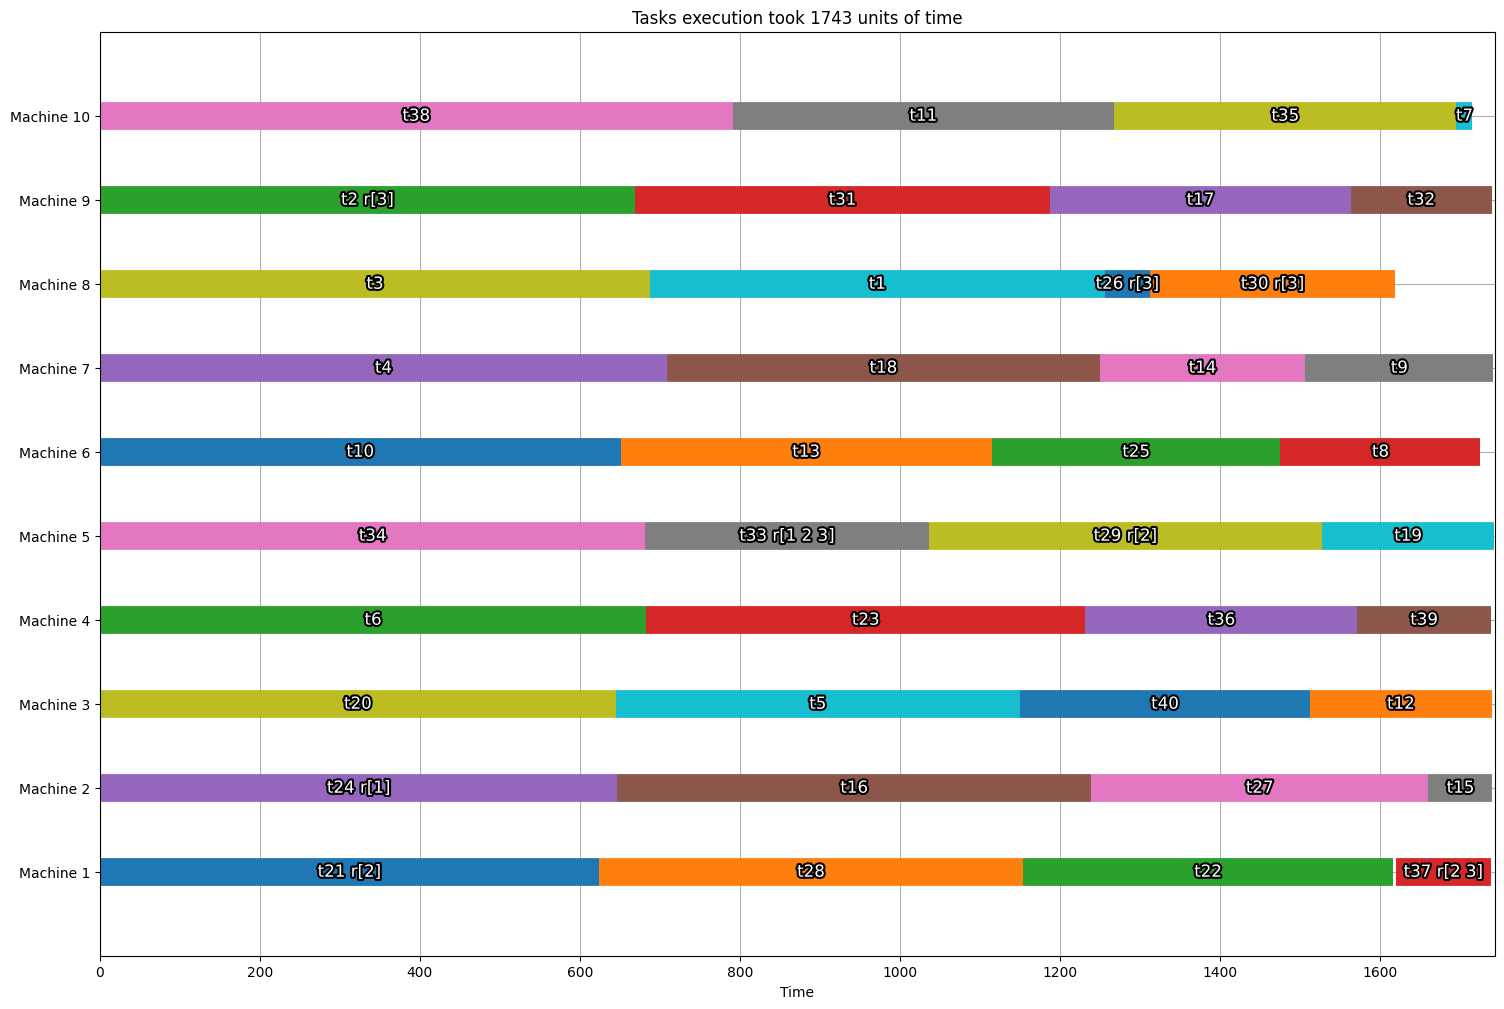

In [24]:
if result in (SAT, OPTIMUM): #drawing the result
    activities = []
    global machines_usages
    for machine in machines_usages:
        machine_activities = []
        for activity, start_time in sorted(machine.items(), key=lambda item: item[1]):
            name, _, _ = activity.split(', ')
            name = name.split('=')[0]  # Extracting the activity name
            start_time = int(start_time)
            duration = int(activity.split(', ')[-1].split('=')[-1])
            machine_activities.append({'name': name, 'start_time': start_time, 'duration': duration})
        activities.append(machine_activities)
    draw_schedule(activities, value(score), max(18, int(value(score)/100)), max(12, int(nMachines/2)))

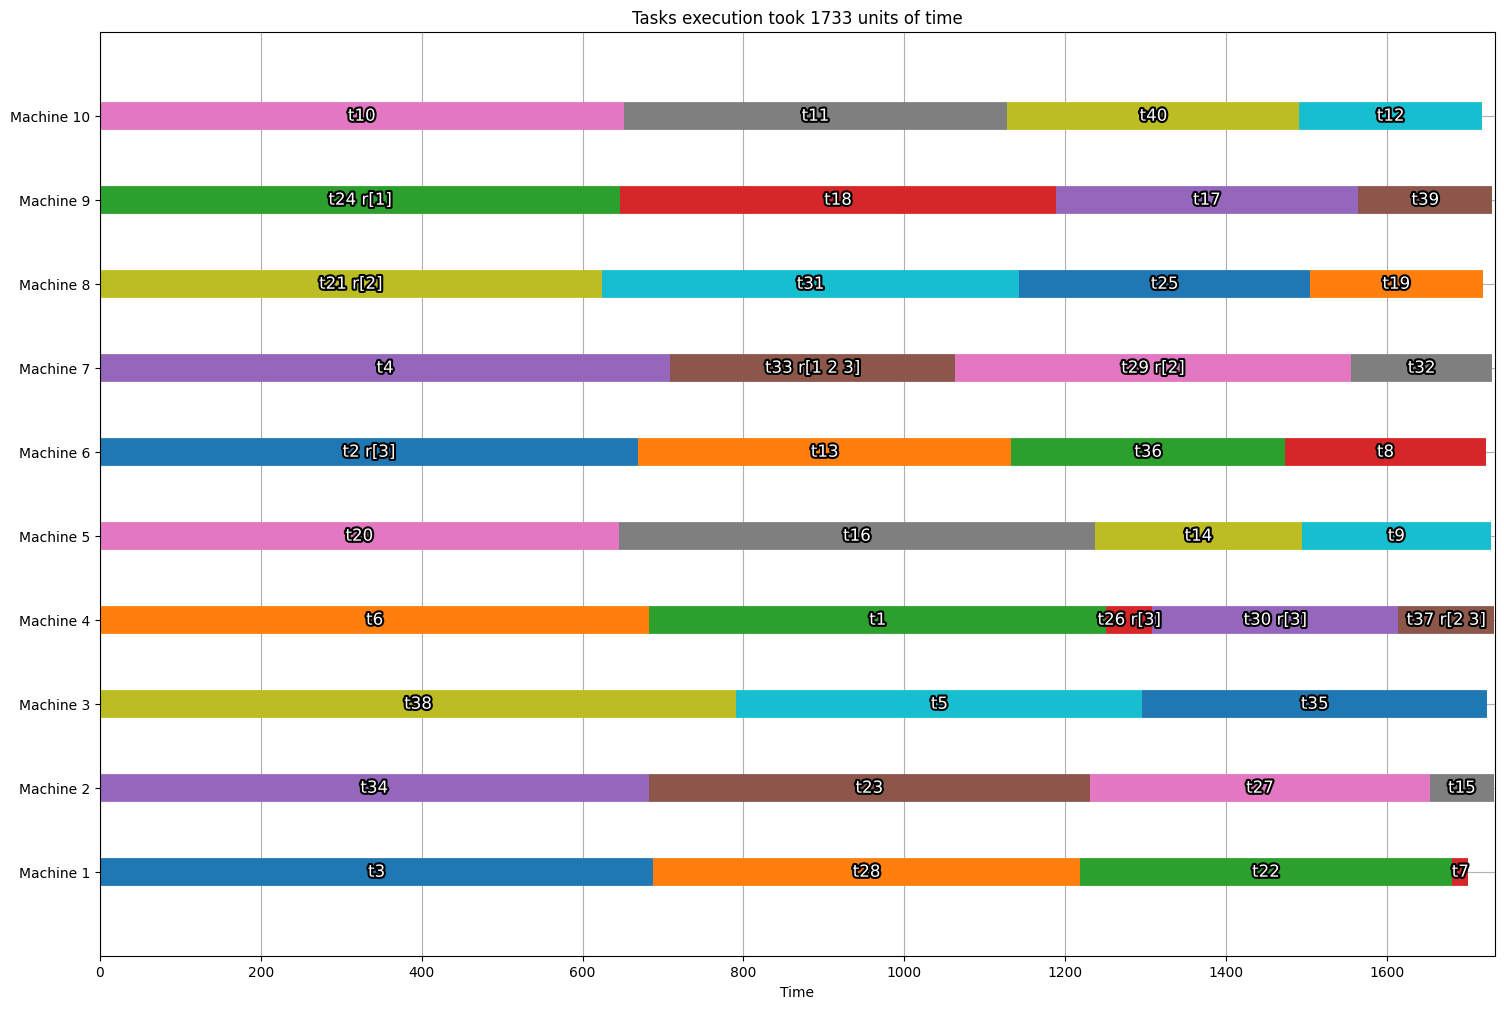

In [ ]:
if result in (SAT, OPTIMUM): #drawing the result
    activities = []
    global machines_usages
    for machine in machines_usages:
        machine_activities = []
        for activity, start_time in sorted(machine.items(), key=lambda item: item[1]):
            name, _, _ = activity.split(', ')
            name = name.split('=')[0]  # Extracting the activity name
            start_time = int(start_time)
            duration = int(activity.split(', ')[-1].split('=')[-1])
            machine_activities.append({'name': name, 'start_time': start_time, 'duration': duration})
        activities.append(machine_activities)
    draw_schedule(activities, value(score), max(18, int(value(score)/100)), max(12, int(nMachines/2)))